In [411]:
using PyPlot
using QuadGK
using GSL

In [401]:
# masses
mB = 5.279;
mJpsi = 3.686; # 3.01;
mπ = 0.139;
mK = 0.485;
mKs = 1.414;
ΓKs = 0.232;
mμ = 0.105;

# kinematica functions
λ(x,y,z) = x^2+y^2+z^2-2*x*y-2*y*z-2*z*x;
ph(s) = sqrt(λ(s,mπ^2,mK^2)*λ(s,mJpsi^2,mB^2))/s;
function project_general(s,cS,cD,A10,A11)
    ph(s)*(abs(A10(s,cS,cD))^2+2*abs(A11(s,cS,cD))^2)
end

# Clebsches and d-function
function ClebschGordon(j1,m1,j2,m2,j,m)
    factor = (j1+j2-m)%2==1 ? -1 : 1
    factor*sqrt(2*j+1)*sf_coupling_3j(2*j1,2*j2,2*j,2*m1,2*m2,-2*m)
end

# breit-wigner
bw(s,msq,Γ)=1/(msq-s-1.0im*sqrt(msq)*Γ)
# Blatt-Weisskopf factors
BWs = [z->1./(1.+z), z->1./(9+3*z+z^2)]
Rbw=5; # /GeV
BWsDwave(s) = BWs[1](λ(s,mπ^2,mK^2)/(4*s)*Rbw^2)*BWs[2](λ(s,mJpsi^2,mB^2)/(4*s)*Rbw^2);

# our amplitude
function A10_our(s,cS,cD)
    j = 1
    lam=0
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    K00 = 2*mJpsi/sqrt(λ(s,mJpsi^2,mB^2))
    K00*(p*q)^j*(s+mJpsi^2-mB^2)/(2*mJpsi^2)*(
        sqrt((2*j-1)/(2*j+1))*ClebschGordon(j-1,0,1,0,j,0)*cS+
        λ(s,mJpsi^2,mB^2)*sqrt((2*j+3)/(2*j+1))*ClebschGordon(j+1,0,1,0,j,0)*cD)
end
function A11_our(s,cS,cD)
    j = 1
    lam=0
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    K10 = q
    K10*(p*q)^(j-1)*(
        sqrt((2*j-1)/(2*j+1))*ClebschGordon(j-1,0,1,1,j,1)*cS+
        λ(s,mJpsi^2,mB^2)*sqrt((2*j+3)/(2*j+1))*ClebschGordon(j+1,0,1,1,j,1)*cD)
end

# LS amplitude scattering
function A1λ_LS_sc(s,cS,cD,lam)
    j = 1
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    p^(j-1)*q^j*(
        sqrt((2*j-1)/(2*j+1))*ClebschGordon(j-1,0,1,lam,j,lam)*cS+
        sqrt((2*j+3)/(2*j+1))*ClebschGordon(j+1,0,1,lam,j,lam)*p^2*cD)
end
A10_LS_sc(s,cS,cD) = A1λ_LS_sc(s,cS,cD,0)
A11_LS_sc(s,cS,cD) = A1λ_LS_sc(s,cS,cD,1)

# LS amplitude decay
function A1λ_LS_dc(s,cS,cD,lam)
    j = 1
    p = sqrt(λ(s,mJpsi^2,mB^2))/(2*mB)
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    p^(j-1)*q^j*(
        sqrt((2*j-1)/(2*j+1))*ClebschGordon(j-1,0,1,lam,j,lam)*cS+
        sqrt((2*j+3)/(2*j+1))*ClebschGordon(j+1,0,1,lam,j,lam)*p^2*cD)
end
A10_LS_dc(s,cS,cD) = A1λ_LS_dc(s,cS,cD,0)
A11_LS_dc(s,cS,cD) = A1λ_LS_dc(s,cS,cD,1)

# tensor decay amplitude
function A10_ten_dc(s,cS,cD)
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    γ = (mB^2+s-mJpsi^2)/(2*mB*sqrt(s))
    E1 = (s+mJpsi^2-mB^2)/(2*sqrt(s))
    q*(E1/mJpsi*cS - γ*p^2*s/mB^2*(s-mJpsi^2-mB^2)/(2*mJpsi*mB)*cD)
end
function A11_ten_dc(s,cS,cD)
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    q*(cS + p^2/2*s/mB^2*cD)
end

# tensor scattering amplitude
function A10_ten_sc(s,cS,cD)
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    E1 = (s+mJpsi^2-mB^2)/(2*sqrt(s))
    E1/mJpsi*q*(cS - p^2*cD)
end
function A11_ten_sc(s,cS,cD)
    p = sqrt(λ(s,mJpsi^2,mB^2)/(4*s))
    q = sqrt(λ(s,mπ^2,mK^2)/(4*s))
    q*(cS + p^2/2*cD)
end

func0 = [s->(project_general(s,0,1,A10_our,A10_our)),
        s->(project_general(s,0,1,A10_ten_sc,A11_ten_sc)),
        s->(project_general(s,0,1,A10_ten_dc,A11_ten_dc)),
        s->(project_general(s,0,1,A10_LS_sc,A11_LS_sc)),
        s->(project_general(s,0,1,A10_LS_dc,A11_LS_dc))
        ]

project_general(1.1,0,1,A10_our,A11_our),
project_general(1.1,0,1,A10_LS_sc,A11_LS_sc),
project_general(1.1,0,1,A10_LS_dc,A11_LS_dc),
project_general(1.1,0,1,A10_ten_dc,A11_ten_dc),
project_general(1.1,0,1,A10_ten_sc,A11_ten_sc)

(37823.59397329053, 860.3161058479768, 1.3404072730480026, 3.45102033823637, 2930.5470537156925)

Adjustment of matplotlib

In [ ]:
# font
PyCall.PyDict(matplotlib["rcParams"])["font.family"] = "serif"
PyCall.PyDict(matplotlib["rcParams"])["font.serif"] = "Palatino"
PyCall.PyDict(matplotlib["rcParams"])["font.size"] = 15                            
# latex
PyCall.PyDict(matplotlib["rcParams"])["text.usetex"] = true
PyCall.PyDict(matplotlib["rcParams"])["text.latex.preamble"] = ["\\usepackage{siunitx}"]

Finally plot curves

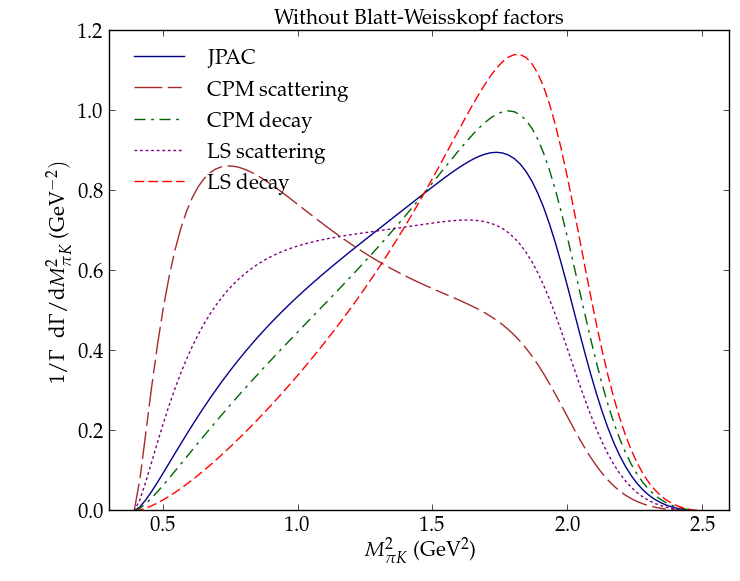

In [409]:
xp = linspace((mπ+mK)^2,(mB-mJpsi)^2,100);
# functions
func = [(s->f(s)*abs(bw(s,mKs^2,ΓKs))^2) for f in func0]
dfunc = [f.(xp) for f in func];
dfunc = [df./(sum(df)*(xp[2]-xp[1])) for df in dfunc];
pl = figure()
# [plot(xp,df) for df in dfunc]
plot(xp, dfunc[1], "-",  label = "JPAC", c="darkblue")
plot(xp, dfunc[2], "-", label = "CPM scattering", dashes=[20, 4, 10, 4], c="brown")
plot(xp, dfunc[3], "-", label = "CPM decay", dashes=[8, 4, 2, 4], c="darkgreen")
plot(xp, dfunc[4], "-", label = "LS scattering", dashes=[2, 2, 2, 2], c = "purple")
plot(xp, dfunc[5], "-", label = "LS decay", dashes=[7, 3, 7, 3], c = "red")
ax = axes()
ax[:set_xlim]([0.3,2.6])
# ax[:set_ylim]([0.0,1.1])
handles, labels  = ax[:get_legend_handles_labels]()
legend(handles, labels, fontsize=15, frameon=false, handlelength=3, loc=2)
# ylabel(L"$\frac{1}{\Gamma}\,\frac{\mathrm{d}\Gamma}{\mathrm{d}M_{\pi K}^2}$ (\si{\GeV}$^{-2})$", fontsize=15)
ylabel(L"$1/\Gamma\enspace\mathrm{d}\Gamma/\mathrm{d}M_{\pi K}^2$ (\si{\GeV}$^{-2})$", fontsize=15)
xlabel(L"$M_{\pi K}^2$ (\si{\GeV}$^{2}$)", fontsize=15)
title("Without Blatt-Weisskopf factors", fontsize=15)
savefig("/tmp/woBW.pdf")

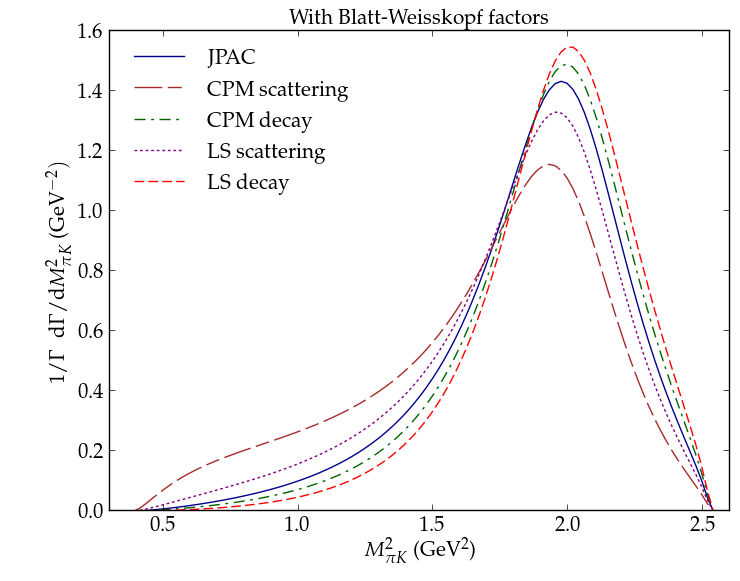

In [410]:
xp = linspace((mπ+mK)^2,(mB-mJpsi)^2,100);
# functions
func = [(s->f(s)*abs(bw(s,mKs^2,ΓKs))^2*BWsDwave(s)) for f in func0]
dfunc = [f.(xp) for f in func];
dfunc = [df./(sum(df)*(xp[2]-xp[1])) for df in dfunc];
pl = figure()
# [plot(xp,df) for df in dfunc]
plot(xp, dfunc[1], "-",  label = "JPAC", c="darkblue")
plot(xp, dfunc[2], "-", label = "CPM scattering", dashes=[20, 4, 10, 4], c="brown")
plot(xp, dfunc[3], "-", label = "CPM decay", dashes=[8, 4, 2, 4], c="darkgreen")
plot(xp, dfunc[4], "-", label = "LS scattering", dashes=[2, 2, 2, 2], c = "purple")
plot(xp, dfunc[5], "-", label = "LS decay", dashes=[7, 3, 7, 3], c = "red")
ax = axes()
ax[:set_xlim]([0.3,2.6])
handles, labels  = ax[:get_legend_handles_labels]()
legend(handles, labels, fontsize=15, frameon=false, handlelength=3, loc=2)
# ylabel(L"$\frac{1}{\Gamma}\,\frac{\mathrm{d}\Gamma}{\mathrm{d}M_{\pi K}^2}$ (\si{\GeV}$^{-2})$", fontsize=15)
ylabel(L"$1/\Gamma\enspace\mathrm{d}\Gamma/\mathrm{d}M_{\pi K}^2$ (\si{\GeV}$^{-2})$", fontsize=15)
xlabel(L"$M_{\pi K}^2$ (\si{\GeV}$^{2}$)", fontsize=15)
title("With Blatt-Weisskopf factors", fontsize=15)
savefig("/tmp/wBW.pdf")